# Libraries

In [1]:
! pip install transformers timm albumentations --quiet
! pip install ipywidgets --quiet

In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

# Data Import

In [3]:
train_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/train_images"
val_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/val_images"
test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"

# Vision Transformer Model

In [4]:
from transformers import AutoImageProcessor, SwinForImageClassification

# Set the model name to Emiel's fine-tuned Swin model for bird classification
model_name = "Emiel/cub-200-bird-classifier-swin"

# Load the image processor automatically
processor = AutoImageProcessor.from_pretrained(model_name)

# Load the Swin model, specifying the number of classes (200 for CUB-200)
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=20,  # Ensure this matches the number of classes in your dataset
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/786M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# import timm
# model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=20)

## Freeze all feature layers of Swin

In [6]:
# Freeze all parameters in the Swin backbone first.
for param in model.swin.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the last block (layer) of the backbone.
# This assumes that your model.swin has an attribute 'layers' which is a ModuleList.
if hasattr(model.swin, "stages"):
    for param in model.swin.stages[-2].parameters():
        param.requires_grad = True
    print("Unfroze the last stage of the Swin backbone.")

# Ensure the classification head is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

## Set layer-wise learning rate

In [7]:
from transformers import AdamW

# Set layer-wise learning rate (feature layer learning rate is lower)
optimizer = AdamW(
    [
        {"params": model.swin.parameters(), "lr": 1e-5},  # Feature extraction layer
        {"params": model.classifier.parameters(), "lr": 3e-4}  # Classification header
    ],
    weight_decay=0.01
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# Verify that the classification layer is randomly initialized (correct state should be True)
print(model.classifier.weight.mean().item())  # Should be close to 0 (normal distribution initialization)
print(model.classifier.bias.mean().item())    # Should be close to 0

-0.00014581643335986882
0.0


In [9]:
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BirdDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.dataset = ImageFolder(root=main_dir, transform=transform)
        self.class_to_idx = self.dataset.class_to_idx
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((420, 420)),        
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.2),    
    transforms.RandomRotation(degrees=15),   
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  
    transforms.RandomGrayscale(p=0.1),  
    transforms.ToTensor(),  
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])


val_transform = transforms.Compose([
    transforms.Resize((384, 384)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset = BirdDataset(train_dir, transform=train_transform)
val_dataset = BirdDataset(val_dir, transform=val_transform)

def validate_class_order(train_class_order, submission_order):
    """Make sure the category names and order of both lists are exactly the same"""
    if len(train_class_order) != len(submission_order):
        raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
    for train_cls, sub_cls in zip(train_class_order, submission_order):
        if train_cls != sub_cls:
            raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
    return True

train_class_order = sorted(train_dataset.class_to_idx.keys())

try:
    validate_class_order(train_class_order, submission_class_order)
except ValueError as e:
    print("Category order inconsistency detected, automatically correcting...")
    from torchvision.datasets import DatasetFolder
    
    class OrderedImageFolder(DatasetFolder):
        """Forces the data sets of categories to be loaded in a specified order"""
        def __init__(self, root, class_order, transform=None):
            self.class_order = class_order
            super().__init__(
                root,
                loader=lambda x: Image.open(x).convert("RGB"),
                extensions=('jpg', 'jpeg', 'png'),
                transform=transform,
                target_transform=None
            )
            
        def find_classes(self, directory):
            classes = self.class_order 
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
    
    train_dataset = OrderedImageFolder(
        train_dir, 
        class_order=submission_class_order,
        transform=train_transform
    )
    val_dataset = OrderedImageFolder(
        val_dir,
        class_order=submission_class_order,
        transform=val_transform
    )
    
    print("Corrected category order：", train_dataset.classes)
    
# Category index validation (ensuring consistency with submission format)
assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

Category order inconsistency detected, automatically correcting...
Corrected category order： ['Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird', 'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird', 'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird', 'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo', 'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird']


Epoch 01:
Train Loss: 1.7970 | Acc: 0.5005
Val Loss: 0.3652 | Acc: 0.8814

New best model saved with validation accuracy: 0.8814
Epoch 02:
Train Loss: 0.6455 | Acc: 0.8218
Val Loss: 0.1985 | Acc: 0.9280

New best model saved with validation accuracy: 0.9280
Epoch 03:
Train Loss: 0.5158 | Acc: 0.8506
Val Loss: 0.1654 | Acc: 0.9407

New best model saved with validation accuracy: 0.9407
Epoch 04:
Train Loss: 0.4110 | Acc: 0.8751
Val Loss: 0.1496 | Acc: 0.9492

New best model saved with validation accuracy: 0.9492
Epoch 05:
Train Loss: 0.3759 | Acc: 0.8847
Val Loss: 0.1371 | Acc: 0.9449

Epoch 06:
Train Loss: 0.3479 | Acc: 0.8986
Val Loss: 0.1403 | Acc: 0.9492

Epoch 07:
Train Loss: 0.3103 | Acc: 0.9082
Val Loss: 0.1352 | Acc: 0.9492

Epoch 08:
Train Loss: 0.3108 | Acc: 0.9029
Val Loss: 0.1289 | Acc: 0.9449

Epoch 09:
Train Loss: 0.2838 | Acc: 0.9200
Val Loss: 0.1271 | Acc: 0.9492

Epoch 10:
Train Loss: 0.2750 | Acc: 0.9232
Val Loss: 0.1254 | Acc: 0.9534

New best model saved with validati

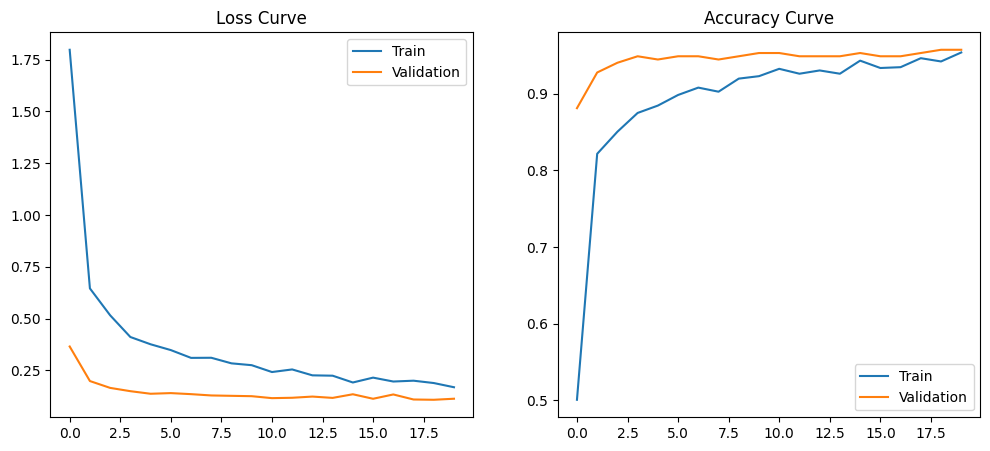

In [11]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# (Assuming train_dataset, val_dataset, model, optimizer, criterion, etc. are already defined)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

scaler = torch.amp.GradScaler('cuda')
early_stopper = EarlyStopper(patience=10, min_delta=0.0003)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Variables to track the best validation accuracy
best_val_acc = 0.0
best_model_path = "/kaggle/working/best_model.pth"

for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1:02d}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n")
    
    # Save model parameters if current validation accuracy is the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping triggered!")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [12]:
import os
import torch

# Define the directory where you'll save the best model in Hugging Face format.
save_dir = "/kaggle/working/swin_model"
os.makedirs(save_dir, exist_ok=True)

# Load the best model state dictionary (from the training loop).
best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))
model.load_state_dict(best_state_dict)

# Save the best model in Hugging Face format.
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

# Optionally, save additional information such as class mapping and training configuration.
class_info = {
    "class_order": submission_class_order,
    "class_to_idx": train_dataset.class_to_idx,
    "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
}
torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

train_config = {
    "epochs_trained": len(history['train_loss']),
    "best_val_acc": max(history['val_acc']),
    "optimizer_state": optimizer.state_dict()
}
torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

# Also save the class order as a plain text file for reference.
with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
    f.write("\n".join(submission_class_order))

print(f"Best model saved in Hugging Face format to: {save_dir}")

<ipython-input-12-cf258f9b96a8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))


Best model saved in Hugging Face format to: /kaggle/working/swin_model


# Test and Generate Submission File

In [13]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, SwinForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

model_dir = "/kaggle/working/swin_model" 
processor = AutoImageProcessor.from_pretrained(model_dir)

expected_size = 384
val_transform = transforms.Compose([
    transforms.Resize((expected_size, expected_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

class CompetitionTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))  # 保持严格顺序
        self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])

def load_trained_model(model_dir, class_order):
    model = SwinForImageClassification.from_pretrained(model_dir).to(device)
    
    config = model.config
    if config.id2label != {i: cls for i, cls in enumerate(class_order)}:
        print("Warning: The order of categories in the model configuration is inconsistent with the submission requirements. Overriding with submission order.")
        config.id2label = {i: cls for i, cls in enumerate(class_order)}
        config.label2id = {cls: i for i, cls in enumerate(class_order)}
    
    model.eval()
    return model

def generate_submission(test_dir, model_dir, output_csv="submission.csv"):
    test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    
    model = load_trained_model(model_dir, submission_class_order)
    
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            outputs = model(images.to(device))
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            filenames.extend(paths)
            predictions.extend(batch_preds.tolist())
    
    submission_df = pd.DataFrame({
        'path': filenames,
        'class_idx': predictions
    })
    
    print("\nValidation Results:")
    print(f"Total Samples: {len(submission_df)}")
    print(f"Number of unique file names: {submission_df['path'].nunique()}")
    print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")
    
    submission_df.to_csv(output_csv, index=False)
    print(f"\nSubmission CSV saved to: {output_csv}")

if __name__ == "__main__":
    test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"
    generate_submission(test_dir, model_dir)


Validation Results:
Total Samples: 400
Number of unique file names: 400
Predicted category distribution:
class_idx
0     19
1     18
2     23
3     20
4     21
5     20
6     16
7     20
8     21
9     22
10    21
11    19
12    19
13    22
14    20
15    22
16    20
17    19
18    18
19    20
Name: count, dtype: int64

Submission CSV saved to: submission.csv
